In [ ]:
# default_exp density_ratio_em

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# export
from multiinstance.em import generateBags
from multiinstance.utils import estimate
from multiinstance.nnpu import getPosterior as getNNPUPosterior

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from easydict import EasyDict
from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

In [ ]:
from multiinstance.data.gaussian_dg import GaussianMixtureDataGenerator

In [ ]:
from dist_curve.transforms import getOptimalTransform

In [ ]:
# export
class DensityRatioEM:
    def __init__(self, bags,n_clusters):
        self.bags = bags
        self.n_clusters = n_clusters
        self.findGlobalClusters()

    def findGlobalClusters(self):
        "Run K-Means on the positives from all bags then assign each unlabeled point to a cluster based on the resulting clusters of K-Means"
        globalPositives = np.concatenate([b.X_pos for b in bags])
        kmeans = KMeans(n_clusters=self.n_clusters).fit(globalPositives)
        # Cluster Unlabeled
        for bagNum,b in enumerate(self.bags):
            self.bags[bagNum].unlabeled_cluster_assignment = kmeans.predict(b.x_unlabeled)
            self.bags[bagNum].positive_cluster_assignment = kmeans.predict(b.X_pos)
        self.kmeans = kmeans

    def getClusterEstimates(self,componentInfo=None):
        "Estimate the class prior and density ratios of the unlabeled points for each cluster"
        self.clusterAlphaHats= np.zeros(self.n_clusters)
        # NClusters x NBags size list containing the density ratio for the unlabeled points
        # from the specified bag in the specified cluster
        self.bagRatios = []
        for cnum in range(self.n_clusters):
            unlabeledInCluster = [b.x_unlabeled[b.unlabeled_cluster_assignment == cnum] for b in self.bags]
            posInCluster = [b.X_pos[b.positive_cluster_assignment == cnum] for b in self.bags]
            unlabeled = np.concatenate(unlabeledInCluster)
            positive = np.concatenate(posInCluster)
            # estimate class prior
            tau, aucpu = getOptimalTransform(np.concatenate((positive, unlabeled)), 
                                         np.concatenate((np.ones(positive.shape[0]),
                                                         np.zeros(unlabeled.shape[0]))))
            tau_pos = np.ascontiguousarray(tau[:positive.shape[0]].reshape((-1,1)))
            tau_u = np.ascontiguousarray(tau[positive.shape[0]:].reshape((-1,1)))
            self.clusterAlphaHats[cnum],_ = estimate(tau_pos, tau_u)
            ####
            #self.clusterAlphaHats[cnum],_ = estimate(positive, unlabeled)
            # Estimate density ratio for all unlabeled points in each bag that are in this cluster
            self.bagRatios.append(self.estimateClusterDensityRatio(posInCluster,
                                                                   unlabeledInCluster,
                                                                   cnum,
                                                                   tau_pos,
                                                                   tau_u,
                                                                   componentInfo))

    def ratioFromPosteriorVec(self, posts, alpha):
        return (alpha * (1 - posts)) / (posts * (1 - alpha))

    def estimateClusterDensityRatio(self,posInCluster,unlabeledInCluster,cnum,tau_pos,tau_u,
                                    componentInfo=None,
                                    args=EasyDict(d={'batchsize': 128,
                                                     'hdim': 300,
                                                     'epochs': 250,
                                                     'lr': 0.001,
                                                     'weightDecayRate': 0.005})):
        p = np.concatenate(posInCluster)
        u = np.concatenate(unlabeledInCluster)
        # PU Labels {1: pos, -1: unlabeled}
        y = np.concatenate((np.ones(p.shape[0]),
                            np.ones(u.shape[0])*-1)).astype(np.int32)
        # Run NNPU
        if componentInfo is None:
            posteriors = getNNPUPosterior(np.concatenate((tau_pos, tau_u)).astype(np.float32),
                                          y,
                                          self.clusterAlphaHats[cnum],
                                          args = args)
            # convert cluster posterior to density ratio
            ratios = np.nan_to_num(self.ratioFromPosteriorVec(posteriors, self.clusterAlphaHats[cnum]))
        else:
            clusterMap = cdist(self.kmeans.cluster_centers_, componentInfo.posMeans).argmin(1)
            # pos
            cnum = clusterMap[cnum]
            f1 = ss.multivariate_normal.pdf(np.concatenate((p,u)),
                                 mean=componentInfo.posMeans[cnum],
                                 cov=componentInfo.posCovs[cnum])
            # Neg
            f0 = ss.multivariate_normal.pdf(np.concatenate((p,u)),
                                 mean=componentInfo.negMeans[cnum],
                                 cov=componentInfo.negCovs[cnum])
            ratios = f0/f1
        
        # Remove positive points from posterior list
        ratios = ratios[p.shape[0]:]
        # Store the ratios for the unlabeled set of each bag
        bagRatios = []
        # Get ratios for unlabeled sets of each bag
        idx = 0
        for bagNum in range(len(posInCluster)):
            numU = unlabeledInCluster[bagNum].shape[0]
            bagRatios.append(ratios[idx:idx+numU])
            idx += numU
        return bagRatios
    
    def EM(self,NIters=500):
        self.eta = np.zeros((len(self.bags), self.n_clusters))
        for cnum in range(self.n_clusters):
            for bagNum, b in enumerate(self.bags):
                ratios = self.bagRatios[cnum][bagNum]
                eta_i_j = np.array(.5)
                for em_iter in range(NIters):
                    den = eta_i_j + (1 - eta_i_j) * ratios
                    eta_i_j = np.mean(eta_i_j / den)
                self.eta[bagNum,cnum] = eta_i_j
    
    def run(self,componentInfo=None):
        
        self.getClusterEstimates(componentInfo)
        self.EM()
        self.estimateBagParameters()
    
    
    def posterior(self, bagNum, clusterNum):
        eta_i_j = self.eta[bagNum, clusterNum]
        densityRatios = self.bagRatios[clusterNum][bagNum]
        return eta_i_j / (eta_i_j + (1 - eta_i_j)*densityRatios)
    
    def getAUC(self):
        labels = []
        posts = []
        for bagNum in range(len(self.bags)):
            for cnum in range(self.n_clusters):
                posts.append(self.posterior(bagNum,cnum))
                labels.append(self.bags[bagNum].hiddenLabels[self.bags[bagNum].unlabeled_cluster_assignment == cnum])
        labels = np.concatenate(labels)
        posts = np.concatenate(posts)
        return roc_auc_score(labels, posts)

    def estimateBagParameters(self):
        N = len(self.bags)
        self.alphaHats = np.zeros(N)
        self.pi = np.zeros((N,self.n_clusters))
        self.rho = np.zeros((N,self.n_clusters))
        for bagNum, b in enumerate(self.bags):
            eta_j = self.eta[bagNum]
            gamma_j = np.unique(b.unlabeled_cluster_assignment,
                                return_counts=True)[1] / b.unlabeled_cluster_assignment.shape[0]
            alpha_j = eta_j.dot(gamma_j)
            pi_j = np.multiply(eta_j, gamma_j) / alpha_j
            rho_j = np.multiply(1 - eta_j, gamma_j) / (1 - alpha_j)
            self.alphaHats[bagNum] = alpha_j
            self.pi[bagNum] = pi_j
            self.rho[bagNum] = rho_j

## Test Method

In [ ]:
posMeans = [[0,-4], [12,6]]
negMeans = [[-0,-0], [8,3]]
bags = generateBags(10,pos_means=posMeans,
                    neg_means=negMeans,
                    pos_covs=[np.eye(2)]*2,
                    neg_covs = [np.eye(2)]*2,
                    NPos=100,NUnlabeled=500)

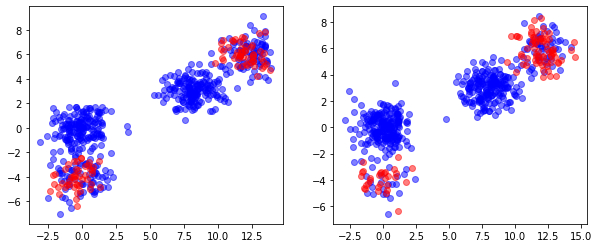

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
for b,a in zip(bags,ax):
    a.scatter(b.x_unlabeled[:,0], b.x_unlabeled[:,1],color="blue",alpha=.5)
    a.scatter(b.X_pos[:,0], b.X_pos[:,1],color="red",alpha=.5)

In [ ]:
drem = DensityRatioEM(bags,len(posMeans))

In [ ]:
# drem.run(componentInfo=EasyDict({"posMeans":posMeans,
#                                  "negMeans":negMeans,
#                                  "posCovs":[np.eye(2)]*2,
#                                  "negCovs":[np.eye(2)]*2}))
drem.run()

KeyboardInterrupt: 

In [ ]:
drem.getAUC()

 Alpha MAE

In [ ]:
np.mean(np.abs(drem.alphaHats - np.array([b.alpha for b in bags])))

# Baseline

In [ ]:
def posteriorCorrection(tau, alpha, S0S1):
    post =  alpha * S0S1 * (tau / (1 - tau))
    post = np.nan_to_num(post)
    return post

def baseline(bags):
    # apply transforms
    posts = []
    labels = []
    absErrs = []
    for b in tqdm(bags,leave=False):
        tau, aucpu = getOptimalTransform(np.concatenate((b.X_pos,
                                                         b.x_unlabeled)), 
                                         np.concatenate((np.ones(b.X_pos.shape[0]),
                                                        np.zeros(b.x_unlabeled.shape[0]))))
        tau_pos = np.ascontiguousarray(tau[:b.X_pos.shape[0]].reshape((-1,1)))
        tau_u = np.ascontiguousarray(tau[b.X_pos.shape[0]:].reshape((-1,1)))
        alphaHat,_ = estimate(tau_pos, tau_u)
        alphaHat = alphaHat.numpy()[0,0]
        absErrs.append(np.abs(alphaHat - b.alpha))
        s0s1 = b.x_unlabeled.shape[0] / b.X_pos.shape[0]
        posts.append(getNNPUPosterior(np.concatenate((tau_pos, tau_u)).astype(np.float32),
                                      np.concatenate((np.ones(tau_pos.shape[0]),
                                                      np.ones(tau_u.shape[0]) * -1)).astype(np.int32),
                                     alphaHat)[tau_pos.shape[0]:])
        #posts.append(posteriorCorrection(tau_u, alphaHat, s0s1))
        labels.append(b.hiddenLabels)
    return roc_auc_score(np.concatenate(labels),
                         np.concatenate(posts)), np.mean(absErrs)

# Experiments

In [ ]:
getNNPUPosterior??

In [ ]:
def generateParams(nClusters, nComps, dim,aucpn_range=[0.8,0.85]):
    posMeans,posCovs,negMeans,negCovs,dgs =[], [],[],[],[]
    for comp in range(nClusters):
        dg = GaussianMixtureDataGenerator(dim,nComps,aucpn_range,100,1000)
        pos,neg = dg.components_pos[0], dg.components_neg[0]
        r = np.zeros(dim)
        for _ in range(1):
            r += np.random.normal(loc=0,scale=10,size=dim)
        posMeans.append(pos.mean+r)
        posCovs.append(pos.cov)
        negMeans.append(neg.mean+r)
        negCovs.append(neg.cov)
        dgs.append(dg)
    return posMeans,posCovs, negMeans,negCovs,dgs

In [ ]:
NClusters = 3
Dim = 5
aucpn_range=  [.8,1.]
NBags = 100
NPos = 100
NUnlabeled = 250

posMeans,posCovs,negMeans,negCovs,dgs = generateParams(NClusters,1,Dim,aucpn_range=aucpn_range)

bags = generateBags(NBags,
                    pos_means=posMeans,
                    neg_means=negMeans,
                    pos_covs=posCovs,
                    neg_covs=negCovs,
                    NPos=NPos,NUnlabeled=NUnlabeled)

In [ ]:
# fig,ax = plt.subplots(1,2,figsize=(10,4))
# for b,a in zip(bags,ax):
#     a.scatter(b.x_unlabeled[:,0], b.x_unlabeled[:,1],color="blue",alpha=.5)
#     a.scatter(b.X_pos[:,0], b.X_pos[:,1],color="red",alpha=.5)

In [ ]:
print("* NClusters: {}\n* Dim:{}\n* auc_pn_range:{}\n* NBags:{}\n* NPos:{}\n* NUnlabeled:{}\n".format(NClusters,
                                                                                        Dim,
                                                                                        aucpn_range,
                                                                                        NBags,
                                                                                        NPos,
                                                                                        NUnlabeled))
drem = DensityRatioEM(bags,len(posMeans))
# True Posterior
print("\n**True PN Posterior**\n")
drem.run(componentInfo=EasyDict({"posMeans":posMeans,
                   "posCovs":posCovs,
                   "negMeans":negMeans,
                   "negCovs":negCovs}))
print("* AUC:{:.3f}\n* MAE:{:.3f}\n".format(drem.getAUC(),np.mean(np.abs(drem.alphaHats - [b.alpha for b in drem.bags]))))
# DREM
drem.run()
print("**DREM**\n")
print("* AUC:{:.3f}\n* MAE:{:.3f}".format(drem.getAUC(),np.mean(np.abs(drem.alphaHats - [b.alpha for b in drem.bags]))))
# Baseline
print("\n**Baseline**\n")
print("* AUC:{:.3f}\n* MAE:{:.3f}".format(*baseline(bags)))


# Results V3

* NClusters: 3
* Dim:5
* auc_pn_range:[0.8, 1.0]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.875
* MAE:0.036

**DREM**

* AUC:0.620
* MAE:0.152

**Baseline**

* AUC:0.585
* MAE:0.185

# Results V2

## Experiment 1
* NClusters: 3
* Dim:2
* auc_pn_range:[0.9, 1.0]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.934
* MAE:0.023

**DREM**

* AUC:0.671
* MAE:0.172

**Baseline**

* AUC:0.615
* MAE:0.186

## Experiment 2
* NClusters: 3
* Dim:5
* auc_pn_range:[0.9, 1.0]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.932
* MAE:0.018

**DREM**

* AUC:0.888
* MAE:0.093

**Baseline**

* AUC:0.595
* MAE:0.168

## Experiment 3
* NClusters: 3
* Dim:5
* auc_pn_range:[0.8, 0.9]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.882
* MAE:0.039

**DREM**

* AUC:0.758
* MAE:0.128

**Baseline**

* AUC:0.591
* MAE:0.168

## Experiment 4
* NClusters: 3
* Dim:10
* auc_pn_range:[0.8, 0.9]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.879
* MAE:0.038

**DREM**

* AUC:0.500
* MAE:0.489

**Baseline**

* AUC:0.563
* MAE:0.191

## Experiment 5
* NClusters: 3
* Dim:10
* auc_pn_range:[0.9, 1.0]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.929
* MAE:0.025

**DREM**

* AUC:0.500
* MAE:0.520

**Baseline**

* AUC:0.568
* MAE:0.203

## Experiment 6
* NClusters: 3
* Dim:10
* auc_pn_range:[0.95, 1.0]
* NBags:100
* NPos:100
* NUnlabeled:250


**True PN Posterior**

* AUC:0.966
* MAE:0.018

**DREM**

* AUC:0.564
* MAE:0.329

**Baseline**

* AUC:0.616
* MAE:0.158

# Results v1
**Experiment 1**

* 3 Clusters
* 2D
* AUC in [0.99,1]
* 100 bags
* 100P / 250U

**DREM**

* AUC: 0.982
* MAE: 0.027

*Local*
* 0.877
* 0.088

**Experiment 2**

* 3 Clusters
* 5D
* AUC in [0.99,1]
* 100 bags
* 100P / 250U

**DREM**

* AUC: 0.990
* MAE: 0.0420

*Local*
* AUC: 0.784
* MAE: 0.154


**Experiment 3**

* 2 Clusters
* 2D
* AUC in [0.9,1]
* 100 bags
* 100P / 250U

**DREM**

* AUC: 0.915
* MAE: 0.051

*Local*
* AUC: 0.695
* MAE: 0.198

**Experiment 4**
* 2 clusters
* 2D
* AUCPN in [0.8,0.9]
* 100 bags
* 100P / 250U

**DREM**
* 0.836
* 0.103

*Local*
* 0.64
* 0.22

**Experiment 5**
* 3 Clusters
* 5D
* AUCPN [0.8,0.9]
* 100 bags
* 100P /250U

**DREM**
* AUC: 0.6085
* MAE: 0.2153

*Local*
* AUC: .587
* MAE: 0.191

**Experiment 5**
* 3 Clusters
* 5D
* AUCPN [0.7,0.8]
* 100 bags
* 100P /250U

*DREM*
* AUC: 0.5
* MAE: 0.5

**Local**
* AUC: .536
* MAE: 0.194

**Experiment 6**
* 5 Clusters
* 10D
* AUCPN [0.7,0.8]
* 100 bags
* 100P /250U

**DREM**
* AUC: 0.617
* MAE: 0.242

*Local*
* AUC: .53
* MAE: 0.22

**Experiment 7**
* 5 Clusters
* 10D
* AUCPN [0.9, 1.0]
* 100 bags
* 100P /250U

*DREM*
* AUC: 0.61
* MAE: 0.25

**Local**
* AUC: .63
* MAE: 0.2

